# KMeans and CLIP unsupervised style classification


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Get CLIP Embeddings for images

In [ ]:
# Install CLIP from OpenAI
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8g03vlh2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8g03vlh2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import clip
import glob
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load saved models to use in future tests
import joblib
import os
import numpy as np

pca = joblib.load("/content/drive/MyDrive/art_dna/models/pca_model.joblib")
kmeans = joblib.load("/content/drive/MyDrive/art_dna/models/kmeans_model.joblib")

In [ ]:
# Load CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.7MiB/s]


In [ ]:
image_folder = '/content/drive/My Drive/art_dna/raw_data/resized'

In [ ]:
save_folder = "/content/drive/MyDrive/art_dna/clip_embeddings"  # Folder to save outputs
os.makedirs(save_folder, exist_ok=True)

In [ ]:
# === Load all .jpg images and sort ===
all_images = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

# === Batch settings ===
batch_size = 1000
num_batches = (len(all_images) + batch_size - 1) // batch_size

# === Process in batches ===
for batch_idx in range(num_batches):
    start = batch_idx * batch_size
    end = min((batch_idx + 1) * batch_size, len(all_images))
    batch_images = all_images[start:end]

    # Define paths to save this batch's results
    embed_path = os.path.join(save_folder, f"clip_embeddings_batch_{batch_idx}.npy")
    names_path = os.path.join(save_folder, f"clip_filenames_batch_{batch_idx}.txt")

    # Skip batch if already processed
    if os.path.exists(embed_path):
        try:
            data = np.load(embed_path)
            if data.shape[0] == batch_size:
                print(f"[Batch {batch_idx}] Already processed. Skipping.")
                continue
        except:
            print(f"[Batch {batch_idx}] File corrupted. Will reprocess.")

    print(f"[Batch {batch_idx}] Processing {len(batch_images)} images...")

    batch_embeddings = []
    batch_filenames = []

    for path in tqdm(batch_images):
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model.encode_image(image)
            batch_embeddings.append(embedding.cpu().numpy())
            batch_filenames.append(os.path.basename(path))
        except Exception as e:
            print(f"Failed on {path}: {e}")

    # Save embeddings and filenames
    np.save(embed_path, np.vstack(batch_embeddings))
    with open(names_path, "w") as f:
        for name in batch_filenames:
            f.write(name + "\n")

print("✅ All batches processed and saved.")

[Batch 0] Processing 1000 images...


100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


[Batch 1] Processing 1000 images...


100%|██████████| 1000/1000 [00:23<00:00, 42.75it/s]


[Batch 2] Processing 1000 images...


100%|██████████| 1000/1000 [00:20<00:00, 47.69it/s]


[Batch 3] Processing 1000 images...


100%|██████████| 1000/1000 [00:19<00:00, 52.28it/s]


[Batch 4] Processing 1000 images...


100%|██████████| 1000/1000 [00:18<00:00, 53.11it/s]


[Batch 5] Processing 1000 images...


100%|██████████| 1000/1000 [00:20<00:00, 47.90it/s]


[Batch 6] Processing 1000 images...


100%|██████████| 1000/1000 [00:19<00:00, 50.99it/s]


[Batch 7] Processing 1000 images...


100%|██████████| 1000/1000 [00:22<00:00, 44.67it/s]


[Batch 8] Processing 365 images...


100%|██████████| 365/365 [00:07<00:00, 45.93it/s]

✅ All batches processed and saved.


In [ ]:
#merge all embedding batches into one array

embedding_files = sorted(glob.glob("/content/drive/MyDrive/art_dna/clip_embeddings/clip_embeddings_batch_*.npy"))
filename_files = sorted(glob.glob("/content/drive/MyDrive/art_dna/clip_embeddings/clip_filenames_batch_*.txt"))

all_embeddings = np.vstack([np.load(f) for f in embedding_files])

all_filenames = []
for fname in filename_files:
    with open(fname) as f:
        all_filenames.extend(line.strip() for line in f)

print(f"Combined: {len(all_embeddings)} embeddings, {len(all_filenames)} filenames")

Combined: 8365 embeddings, 8365 filenames


## 2. Use KMeans to visualize clusters

In [ ]:
n_clusters = 18
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

In [ ]:
# Map image names to their cluster
#image_clusters = list(zip(all_filenames, cluster_labels))
#for name, cluster in image_clusters:
    #print(f"{name} → Cluster {cluster}")

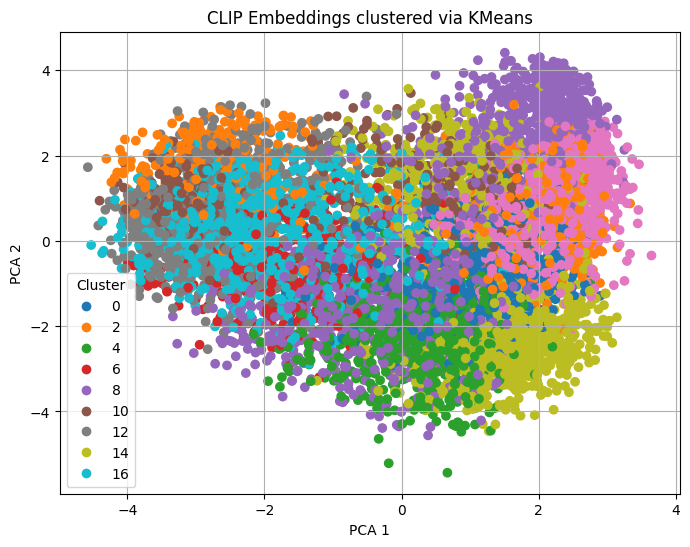

In [ ]:
#Visualize with PCA

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=cluster_labels, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("CLIP Embeddings clustered via KMeans")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [ ]:
import joblib

save_folder = "/content/drive/MyDrive/art_dna/models"
os.makedirs(save_folder, exist_ok=True)

# Save PCA and KMeans
#joblib.dump(pca, f"{save_folder}/pca_model_v2.joblib")
#joblib.dump(kmeans, f"{save_folder}/kmeans_model_v2.joblib")

['/content/drive/MyDrive/art_dna/models/kmeans_model.joblib']

## 3. Match Clusters to Text Prompts Using CLIP

In [ ]:
# Define style prompts
style_prompts = [
    'Abstractionism', 'Art Nouveau', 'Baroque',
    'Byzantine Art', 'Cubism', 'Expressionism',
    'Impressionism', 'Mannerism', 'Muralism',
    'Neoplasticism', 'Pop Art', 'Primitivism',
    'Realism', 'Renaissance', 'Romanticism',
    'Suprematism', 'Surrealism', 'Symbolism'
]

In [ ]:
# Tokenize text prompts and compute their CLIP embeddings
text_tokens = clip.tokenize(style_prompts).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()

# Save text prompts and embeddings
np.save(os.path.join(save_folder, "style_text_embeddings.npy"), text_embeddings)

with open(os.path.join(save_folder, "style_prompts.txt"), "w") as f:
    for prompt in style_prompts:
        f.write(prompt + "\n")

print("✅ Saved style prompts and embeddings to Drive.")

✅ Saved style prompts and embeddings to Drive.


In [ ]:
# Load text embeddings from Drive

text_embeddings_path = os.path.join(save_folder, "style_text_embeddings.npy")
text_embeddings = np.load(text_embeddings_path)

print(f"✅ Loaded text embeddings from {text_embeddings_path}")

✅ Loaded text embeddings from /content/drive/MyDrive/art_dna/clip_embeddings/style_text_embeddings.npy


In [ ]:
from scipy.optimize import linear_sum_assignment

for i, center in enumerate(kmeans.cluster_centers_):
    similarities = np.dot(text_embeddings, center.T)

    # Step 1: Compute similarity matrix (18 styles × 18 clusters)
    style_prompt_count = len(style_prompts)
    cluster_count = len(kmeans.cluster_centers_)

    # Similarities: shape (styles, clusters)
    similarity_matrix = np.zeros((style_prompt_count, cluster_count))

    for i, style_emb in enumerate(text_embeddings):
        for j, center in enumerate(kmeans.cluster_centers_):
            similarity_matrix[i, j] = np.dot(style_emb, center)

    # Convert to cost matrix (negative because we want to maximize similarity)
    cost_matrix = -similarity_matrix

    # Solve linear assignment problem
    style_indices, cluster_indices = linear_sum_assignment(cost_matrix)

    # Build mapping
    cluster_to_style = {}
    for s_idx, c_idx in zip(style_indices, cluster_indices):
        style = style_prompts[s_idx]
        score = similarity_matrix[s_idx, c_idx]
        cluster_to_style[c_idx] = (style, score)

In [ ]:
# Print results

print("🎨 Cluster → Style assignments:\n")

for i in range(kmeans.n_clusters):
    if i in cluster_to_style:
        style, score = cluster_to_style[i]
        print(f"Cluster {i} → {style} (Score: {score:.2f})")
    else:
        print(f"Cluster {i} → Not assigned (ambiguous or extra cluster)")

🎨 Cluster → Style assignments:

Cluster 0 → Cubism (Score: 24.51)
Cluster 1 → Expressionism (Score: 29.77)
Cluster 2 → Realism (Score: 20.66)
Cluster 3 → Pop Art (Score: 20.25)
Cluster 4 → Art Nouveau (Score: 23.01)
Cluster 5 → Surrealism (Score: 29.19)
Cluster 6 → Neoplasticism (Score: 23.61)
Cluster 7 → Symbolism (Score: 29.12)
Cluster 8 → Impressionism (Score: 24.50)
Cluster 9 → Suprematism (Score: 20.05)
Cluster 10 → Renaissance (Score: 24.88)
Cluster 11 → Primitivism (Score: 27.32)
Cluster 12 → Byzantine Art (Score: 24.11)
Cluster 13 → Baroque (Score: 22.54)
Cluster 14 → Abstractionism (Score: 32.46)
Cluster 15 → Mannerism (Score: 25.55)
Cluster 16 → Muralism (Score: 24.89)
Cluster 17 → Romanticism (Score: 26.81)


## 4. Upload an image and output the top 5 most similar styles with their similarity scores


Saving Screenshot 2025-08-04 at 10.36.13.png to Screenshot 2025-08-04 at 10.36.13.png


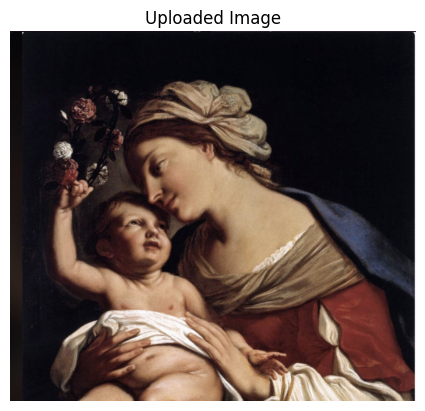

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files

# --- Upload and display the image ---
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

img = Image.open(image_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

In [ ]:
# --- Extract CLIP embedding ---
image_tensor = preprocess(img).unsqueeze(0).to(device)
with torch.no_grad():
    image_embedding = model.encode_image(image_tensor).cpu().numpy()

In [ ]:
# --- Project using the same PCA ---
# This projects the uploaded image embedding into the same PCA space used for visualization.
image_pca = pca.transform(image_embedding)

# --- Predict cluster using KMeans ---
# Predict the cluster of the uploaded image using the KMeans model.
# KMeans prediction should be done on the original embedding space, not the PCA-reduced space.
pred_cluster = kmeans.predict(image_embedding)[0]
print(f"\n📌 Predicted cluster: {pred_cluster}")


📌 Predicted cluster: 10


In [ ]:
# --- Compare cluster center to style prompts ---
cluster_center = kmeans.cluster_centers_[pred_cluster]
similarities = np.dot(text_embeddings, cluster_center.T)
top5_idx = similarities.argsort()[::-1][:5]

print("\n🎨 Top 5 matched styles for this cluster:")
for i in top5_idx:
    print(f"- {style_prompts[i]} (Score: {similarities[i]:.2f})")


🎨 Top 5 matched styles for this cluster:
- Renaissance (Score: 24.88)
- Symbolism (Score: 24.78)
- Mannerism (Score: 24.27)
- Expressionism (Score: 23.95)
- Romanticism (Score: 23.66)


## 5. Visualize nearest images in the same cluster

In [ ]:
# Load images embeddings from Drive
save_folder = "/content/drive/MyDrive/art_dna/clip_embeddings"
all_embeddings_path = os.path.join(save_folder, "all_clip_embeddings.npy")
all_embeddings = np.load(all_embeddings_path)

print(f"✅ Loaded all images embeddings from {all_embeddings_path}")

✅ Loaded all images embeddings from /content/drive/MyDrive/art_dna/clip_embeddings/all_clip_embeddings.npy


In [ ]:
#import joblib
import os
import numpy as np

# Define the path to the saved PCA model
save_folder = "/content/drive/MyDrive/art_dna/models"
pca_model_path = os.path.join(save_folder, "pca_model.joblib")
pca_embeddings_save_path = os.path.join(save_folder, "pca_embeddings.npy")

pca = joblib.load(pca_model_path)
pca_embeddings = pca.transform(all_embeddings)

# Save the PCA embeddings
np.save(pca_embeddings_save_path, pca_embeddings)

In [ ]:
filename_files = sorted(glob.glob("/content/drive/MyDrive/art_dna/clip_embeddings/clip_filenames_batch_*.txt"))
all_filenames = []
for fname in filename_files:
    with open(fname) as f:
        all_filenames.extend(line.strip() for line in f)

/tmp/ipython-input-2029332780.py:21: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


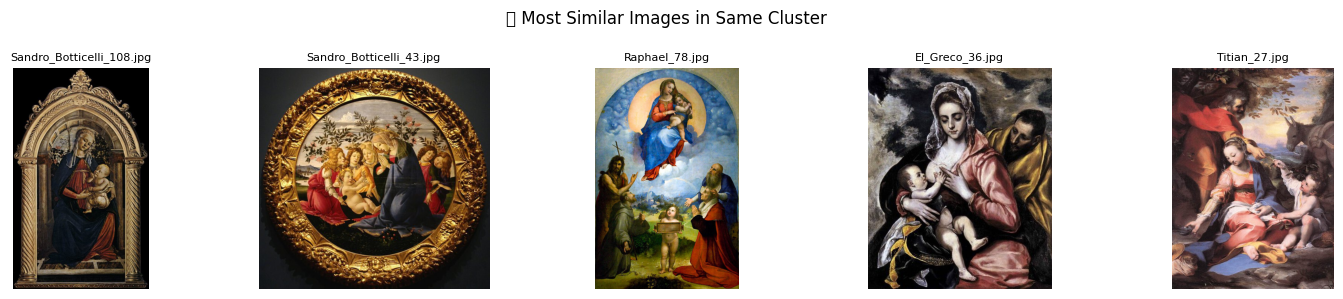

In [ ]:
# --- Get indices of all images in the same cluster ---
same_cluster_indices = np.where(kmeans.labels_ == pred_cluster)[0]

# --- Compute cosine similarity to uploaded image ---
cluster_embeddings = pca_embeddings[same_cluster_indices]  # PCA-reduced image embeddings
sims = cosine_similarity(image_pca, cluster_embeddings)[0]  # Shape: (n_cluster_images,)

# --- Get top 5 most similar images ---
top_indices = sims.argsort()[::-1][:5]
top_image_indices = same_cluster_indices[top_indices]
top_image_names = [all_filenames[i] for i in top_image_indices]

# --- Plot the similar images ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, top_image_names):
    img = Image.open(os.path.join(image_folder, img_path))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(os.path.basename(img_path), fontsize=8)
plt.suptitle("🖼️ Most Similar Images in Same Cluster")
plt.tight_layout()
plt.show()

## 6. Plot similar images with overlaying predicted style label for each retrieved image

/tmp/ipython-input-2146694674.py:15: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


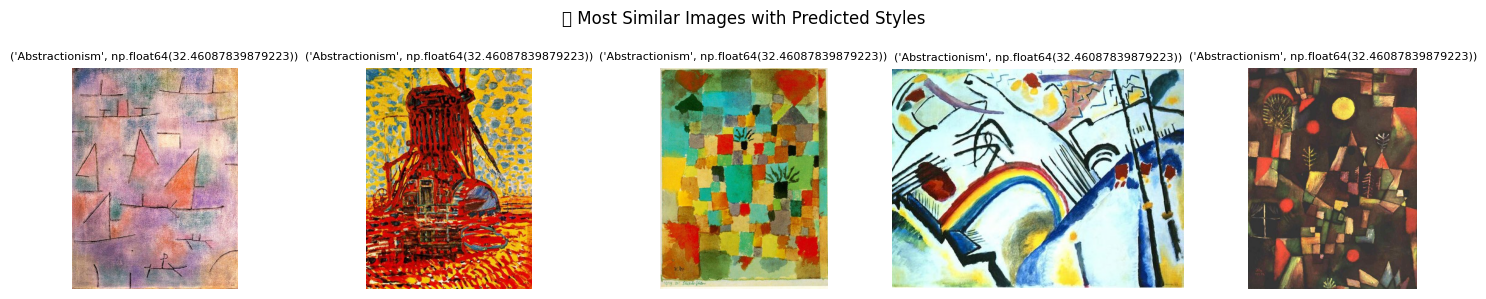

In [ ]:
# --- Plot the similar images with predicted style label ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, img_idx in zip(axes, top_image_indices):
    img_path = all_filenames[img_idx]
    img = Image.open(os.path.join(image_folder, img_path))

    predicted_style = cluster_to_style[kmeans.labels_[img_idx]]

    ax.imshow(img)
    ax.axis("off")
    ax.set_title(predicted_style, fontsize=8)

plt.suptitle("🖼️ Most Similar Images with Predicted Styles")
plt.tight_layout()
plt.show()

## Saving all clip embeddingscombined and pca embeddings on Drive

In [ ]:
#merge all embedding batches into one array

embedding_files = sorted(glob.glob("/content/drive/MyDrive/art_dna/clip_embeddings/clip_embeddings_batch_*.npy"))
filename_files = sorted(glob.glob("/content/drive/MyDrive/art_dna/clip_embeddings/clip_filenames_batch_*.txt"))

all_embeddings = np.vstack([np.load(f) for f in embedding_files])

all_filenames = []
for fname in filename_files:
    with open(fname) as f:
        all_filenames.extend(line.strip() for line in f)

print(f"Combined: {len(all_embeddings)} embeddings, {len(all_filenames)} filenames")

# Save the combined embeddings to Google Drive
save_folder = "/content/drive/MyDrive/art_dna/clip_embeddings"
all_embeddings_save_path = os.path.join(save_folder, "all_clip_embeddings.npy")
np.save(all_embeddings_save_path, all_embeddings)
print(f"✅ Saved combined embeddings to {all_embeddings_save_path}")

Combined: 8365 embeddings, 8365 filenames
✅ Saved combined embeddings to /content/drive/MyDrive/art_dna/clip_embeddings/all_clip_embeddings.npy
